# Draft analysis 

---

Group name: John Anderson Torres Mosquera

---


## Inbound Logistics Forecasting Benchmark

### Introduction

The problem at hand refers to forecasting the inbound material volume (in tons) on monthly basis for the next 4 months for an international automotive company. 

The motivation behind that was the lack of synchronization between suppliers and freight forwarders systems, causing over- or under-capacity planning whenever a plant’s material demands change abruptly, leading to higher logistics transportation costs. 

I published a paper last year about this system, as a result of a research on inbound forecasting systems that I started in 2018. It can be found here [Forecasting System for Inbound Logistics Material Flows at an International Automotive Company](https://www.mdpi.com/2673-4591/39/1/75). Howerver this codebase was written in R using the forecasting package [forecast](https://cran.r-project.org/package=forecast) by Robert Hyndman and George Athanasopoulos in their book [Forecasting at Scale](https://otexts.com/fpp3/). It included algorithms like SARIMA, Exponential Smoothing, Multilayer Neural Networks, Prophet and Vector Autoregression. At that point in time the python packages for timeseries forecasting were not as good as R's. However, the python ecosystem for forecasting has grown a lot in the recent years. There are Python packages like [nitxla](https://nixtlaverse.nixtla.io/), [lightgbm](https://lightgbm.readthedocs.io/en/latest/Python-API.html), [catboost](https://catboost.ai/), as well as LLM forecasting models like [chronos](https://huggingface.co/amazon/chronos-t5-large) that offer many additional functionalities to leverage the use of new algorithms. 

In the M5 competition results [link](https://www.sciencedirect.com/science/article/pii/S0169207021001874) it was shown that boosted tree models can outperform traditional statistical and deep learning forecasting methods. This is something we will be exploring in this project. 

In addition, I would like to use the historical covid numbers from the [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/covid-19/data) to evaluate the influence of this variable on the accuracy of the predictions. This is something that has not been explored in research.

### Research question

Which new methods can be used to improve the forecasting accuracy for the Inbound Logistics Volume of an International Automotive Company?

The idea is to create a forecasting system which is accurate and robust to adapt for outliers and unexpected events( e.g. COVID-19). To evaluate the forecast accuracy the `MAE (Mean Absolute Error)` and `SMAPE (Symmetric Mean Absolute Error)` will be used. This will allow us to care about the fact that in some months the transportation volume could have been 0. 

The test timeframes are: 
- Jan 2022 - Apr 2022
- May 2022 - Aug 2022
- Jul 2022 - Oct 2022

This means that models tested in each frame can only be trained with data prior to that frame to avoid data leakage. 

One of the main Business KPI's to track forecast accuracy will be how many timeseries are in a particular `SMAPE` range, for that we will use the following intervals: 

- 0% to 10%
- 10 to 20%
- 20 to 30%
- 30 to 40%
- greater than 40%


The business experts are particularly interested in having a forecating systems for which most of the timeseries have a `SMAPE` of less or equal than 20%.

### Hypothesis

There are new forecasting methods which can deliver better accuracy than traditional statistical methods.


## Data description

There are two dataset, one containing the historical volume data, another one containing the production data. In total there are:

- 624  inbound logistics Provider-Plant connections
- 18  plants
- 38  Providers

The historical transport volume data contains data since 2014-01-01 until 2022-10-01.
The historical production data contains data since 2014-01-01 until 2023-12-01. All data until October 2022 is actual produced values, the rest are planning values.

The two input data sources for this project are:

- **Inbound_Volume_Data.csv** contains the historical transported material volume since January 2014 until October 2022 on monthly basis. This data comes from the Logistics Parts Mangement System. 
    - **Timestamp**: Monthly data of the format YYYY/MM.
    - **Provider**: Logistics Service Provider.
    - **Plant**: Assembly Plant. 
    - **Actual Vol [Kg]**: Actual transported volume from Provider to Plant in kg. 
    - **Expected Vol [Kg]**: Expected transported volume from Provider to Plant in kg. $^1$
- **production_data.csv** contains the historical production levels of all the european plants in number of vehicles per month from January 2014 until October 2022. Data after October 2022 refers to planned production values. 
    - **Timestamp**:  Monthly data of the format YYYY/MM.
    - **Plant_X**: Column containing the production level for Plant X.

$^1$ *Expected in this context means the volume value which the internal ERP system would calculate. That means, given the number of units in the call-off order and using the weights of the parts, the total expected weight of a delivery can be calculated. However, as mentioned before, due to the sync issue, the delivered volume and expected volume would differ.*

Additionally, I will use the **monthly_covid_rate_per_country.parquet** file, which is generated after pivoting the file **Covid-19_cases_age_specific.csv** to monthly values per country as columns.

- **Covid-19_cases_age_specific.csv**: This data file contains information on the 14-day notification rate of newly reported COVID-19 cases per 100 000 population by age group, week and country. Each row contains the corresponding data for a certain week and country. The file is updated weekly. [source](https://www.ecdc.europa.eu/en/publications-data/covid-19-data-14-day-age-notification-rate-new-cases). The Covid data ranges from 2020-01-06 until 2023-11-20.
    - **country**: Country name
    - **country_code**: cuontry code
    - **year_week**: YYYY-WW data
    - **age_group**: age group
    - **new_cases**: new covid cases
    - **population**: population 
    - **rate_14_day_per_100k**: covid rate per 100.000 inhabitants
    - **source**: Covid source type

- The **monthly_covid_rate_per_country.parquet**, contains the monthly 14-day notification of newly reported COVID-19 cases per 100 000 population per european contry. The Covid data ranges from 2020-01-06 until 2023-11-20. This file is a pivoted version of the original file, for which each row represents a month and each column a country with its corresponding covid cases. Columns are: 
    - **Timestamp**: Monthly date of the format YYYY-MM-DD
    - **Country**: Monthly COVID-19 Rate Per 100k (14-Day Average) in the given country

The **Inbound_Volume_Data** and **production_data** were obtained from the ERP System of the company and were annonymized for research purposes. The Covid **Covid-19_cases_age_specific.csv** data is available on the website of the European Centre for Disease Prevention and Control.

### Data Dictionary

#### Historical Volume Data

In [1]:
import pandas as pd

data_dict_vol = pd.DataFrame({'Name': ['Timestamp', 'Provider', 'Plant', 'Actual_Vol_[Kg]',
       'Expected_Vol_[Kg]', 'Year', 'Month', 'ts_key', 'Actual_Vol_[Tons]',
       'Expected_Vol_[Tons]'], 
                              'Description':['Monthly date of the format YYYY-MM-DD', 
                                             'Logistics Provider ID',
                                             'Assembly Plant ID',
                                             'Actual transported volume from Provider to Plant in kg', 
                                             'Expected transported volume from Provider to Plant in kg', 
                                             'Year in which transport took place', 
                                             'Month in which transport took place',
                                             'Timeseries key', 
                                             'Actual transported volume from Provider to Plant in tons',
                                             'Expected transported volume from Provider to Plant in tons'], 
                              'Role':['ID', 'ID', 'ID', 'response', 'predictor','predictor', 'predictor','ID','predictor','predictor'], 
                              'Type':['ordinal','nominal','nominal', 'numeric','numeric','numeric','numeric','numeric','numeric','numeric'], 
                              'Format':['datetime','category','category','float','float','int','int','category','float','float']
                              })

data_dict_vol

,Name,Description,Role,Type,Format
0,Timestamp,Monthly date of the format YYYY-MM-DD,ID,ordinal,datetime
1,Provider,Logistics Provider ID,ID,nominal,category
2,Plant,Assembly Plant ID,ID,nominal,category
3,Actual_Vol_[Kg],Actual transported volume from Provider to Pla...,response,numeric,float
4,Expected_Vol_[Kg],Expected transported volume from Provider to P...,predictor,numeric,float
5,Year,Year in which transport took place,predictor,numeric,int
6,Month,Month in which transport took place,predictor,numeric,int
7,ts_key,Timeseries key,ID,numeric,category
8,Actual_Vol_[Tons],Actual transported volume from Provider to Pla...,predictor,numeric,float
9,Expected_Vol_[Tons],Expected transported volume from Provider to P...,predictor,numeric,float


#### Historical Production Planning

In [2]:
df_prod = pd.read_parquet("../data/raw/bronze/production_plannig.parquet")
data_dict_prod = pd.DataFrame({'Name': ['Timestamp', 'Plant', 'Production'], 
                              'Description':['Monthly date of the format YYYY-MM-DD', 
                                             'Assembly Plant ID',
                                             'Production Volume in Number of Units', ], 
                              'Role':['ID', 'ID','predictor'], 
                              'Type':['ordinal','nominal', 'numeric'], 
                              'Format':['datetime','category','int']
                              })
data_dict_prod

,Name,Description,Role,Type,Format
0,Timestamp,Monthly date of the format YYYY-MM-DD,ID,ordinal,datetime
1,Plant,Assembly Plant ID,ID,nominal,category
2,Production,Production Volume in Number of Units,predictor,numeric,int


#### Covid Data

In [3]:
data_dict_covid = pd.DataFrame({'Name': ['Timestamp', 'Country'], 
                              'Description':['Monthly date of the format YYYY-MM-DD', 
                                             'Monthly COVID-19 Rate Per 100k (14-Day Average) in the given country'], 
                              'Role':['ID','predictor'], 
                              'Type':['ordinal','numeric'], 
                              'Format':['datetime', 'float']
                              })
data_dict_covid

,Name,Description,Role,Type,Format
0,Timestamp,Monthly date of the format YYYY-MM-DD,ID,ordinal,datetime
1,Country,Monthly COVID-19 Rate Per 100k (14-Day Average...,predictor,numeric,float


## Setup

In [41]:
import os
import json
import sys
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


## Functions

In [ ]:
# Add the parent directory to sys.path
sys.path.insert(0, os.path.abspath('..'))

from src.data_preprocessing import preprocessing_volume_data, preprocessing_production, preprocesing_covid
from src.utils import read_config

## Data

### Config File

In [32]:
config = read_config(yaml_file_path="../config.yaml")

In [33]:
config

{'preprocessing': {'vol_data_path': '../data/raw/inbound_volume_data.csv',
  'prod_data_path': '../data/raw/production_data.csv',
  'covid_data_path': '../data/raw/Covid-19_cases_age_specific.csv',
  'vol_silver_path': '../data/silver/historical_volume_silver.parquet',
  'prod_silver_path': '../data/silver/production_plannig_silver.parquet',
  'covid_silver_path': '../data/silver/monthly_covid_rate_per_country.parquet'}}

### Import data

In [10]:
df_vol = pd.read_csv(config['preprocessing']['vol_data_path'],index_col=0)
df_prod = pd.read_csv(config['preprocessing']['prod_data_path'],index_col=0)
df_covid = pd.read_csv(config['preprocessing']['covid_data_path'])

In [11]:
df_vol.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47058 entries, 0 to 60518
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Timestamp          47058 non-null  object
 1   Provider           47058 non-null  object
 2   Plant              47058 non-null  object
 3   Actual Vol [Kg]    47055 non-null  object
 4   Expected Vol [Kg]  46951 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [12]:
df_vol.head(3)

,Timestamp,Provider,Plant,Actual Vol [Kg],Expected Vol [Kg]
0,2015/07,Provider_1,Plant_1,19096,20298
1,2015/08,Provider_1,Plant_1,187139,189973
2,2015/09,Provider_1,Plant_1,181149,187798


In [13]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120 entries, 0 to 119
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Timestamp  120 non-null    object
 1   Plant_6    120 non-null    int64 
 2   Plant_9    120 non-null    int64 
 3   Plant_13   120 non-null    int64 
 4   Plant_15   120 non-null    int64 
 5   Plant_17   120 non-null    int64 
 6   Plant_19   120 non-null    int64 
 7   Plant_21   120 non-null    int64 
 8   Plant_11   120 non-null    int64 
 9   Plant_4    120 non-null    int64 
 10  Plant_12   120 non-null    int64 
 11  Plant_20   120 non-null    int64 
 12  Plant_14   120 non-null    int64 
 13  Plant_22   120 non-null    int64 
 14  Plant_1    120 non-null    int64 
 15  Plant_3    120 non-null    int64 
 16  Plant_5    120 non-null    int64 
 17  Plant_18   120 non-null    int64 
 18  Plant_10   120 non-null    int64 
dtypes: int64(18), object(1)
memory usage: 18.8+ KB


In [14]:
df_prod.head(3)

,Timestamp,Plant_6,Plant_9,Plant_13,Plant_15,Plant_17,Plant_19,Plant_21,Plant_11,Plant_4,Plant_12,Plant_20,Plant_14,Plant_22,Plant_1,Plant_3,Plant_5,Plant_18,Plant_10
0,2014/01,11848,54138,33839,19438,6770,29098,45147,8578,326919,11668,93855,68067,13127,26363,26363,5799,13749,3633
1,2014/02,13528,53063,36690,24252,6943,26975,42656,9739,334540,11275,92865,66012,18565,29822,29822,7978,12880,2880
2,2014/03,12753,50551,38211,24978,7695,28991,46226,10619,356075,12306,99860,71251,19505,28915,28915,8149,13348,4165


In [15]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35496 entries, 0 to 35495
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               35496 non-null  object 
 1   country_code          35496 non-null  object 
 2   year_week             35496 non-null  object 
 3   age_group             35496 non-null  object 
 4   new_cases             33018 non-null  float64
 5   population            35496 non-null  int64  
 6   rate_14_day_per_100k  32744 non-null  float64
 7   source                35496 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.2+ MB


In [16]:
df_covid.head(3)

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
0,Austria,AT,2020-01,<15yr,NaN,1291589,NaN,TESSy COVID-19
1,Austria,AT,2020-02,<15yr,NaN,1291589,NaN,TESSy COVID-19
2,Austria,AT,2020-03,<15yr,NaN,1291589,NaN,TESSy COVID-19


### Data structure

We can use the python package `networkx` to analyze the structure of the network. We can use the plotting functions to visualize it and understand how the Providers distribute material volume to the plants. First of all, we can model this problem as a bipartite graph, since the forecasting focuses only in the main legs of the Area Forwarding-based Inbound Logistics Network. As shown in the next figure:

<img src="../img/Area_Forwarding_based_inbound_logistics.png" alt="moirai model" width=600>

In [17]:
# Define nodes and edges
provider_nodes = df_vol['Provider'].to_list()
plant_nodes = df_vol['Plant'].to_list()
network_tuples_edges = [(x, y) for x, y in df_vol[['Provider', 'Plant']].drop_duplicates().values]

# Create Bipartite directed Graph
inbound_log_graph = nx.DiGraph()
inbound_log_graph.add_nodes_from(provider_nodes, bipartite=0)
inbound_log_graph.add_nodes_from(plant_nodes, bipartite=1)
inbound_log_graph.add_edges_from(network_tuples_edges)

# Graph Metrics
num_edges = inbound_log_graph.number_of_edges()
num_nodes = inbound_log_graph.number_of_nodes()
print(f"Number of main leg connection (edges) in the network: {num_edges}")
print(f"Number of nodes in the network: {num_nodes}")

Number of main leg connection (edges) in the network: 624
Number of nodes in the network: 56


The following image provide a good representation of the bipartite behaviour of the network. Since we only focus on the main leg, the network complexity is simplified. So that we can later either forecast the individual edges or also take into account cross-correlations among different Providers, when they deliver material flow to the same Plant.

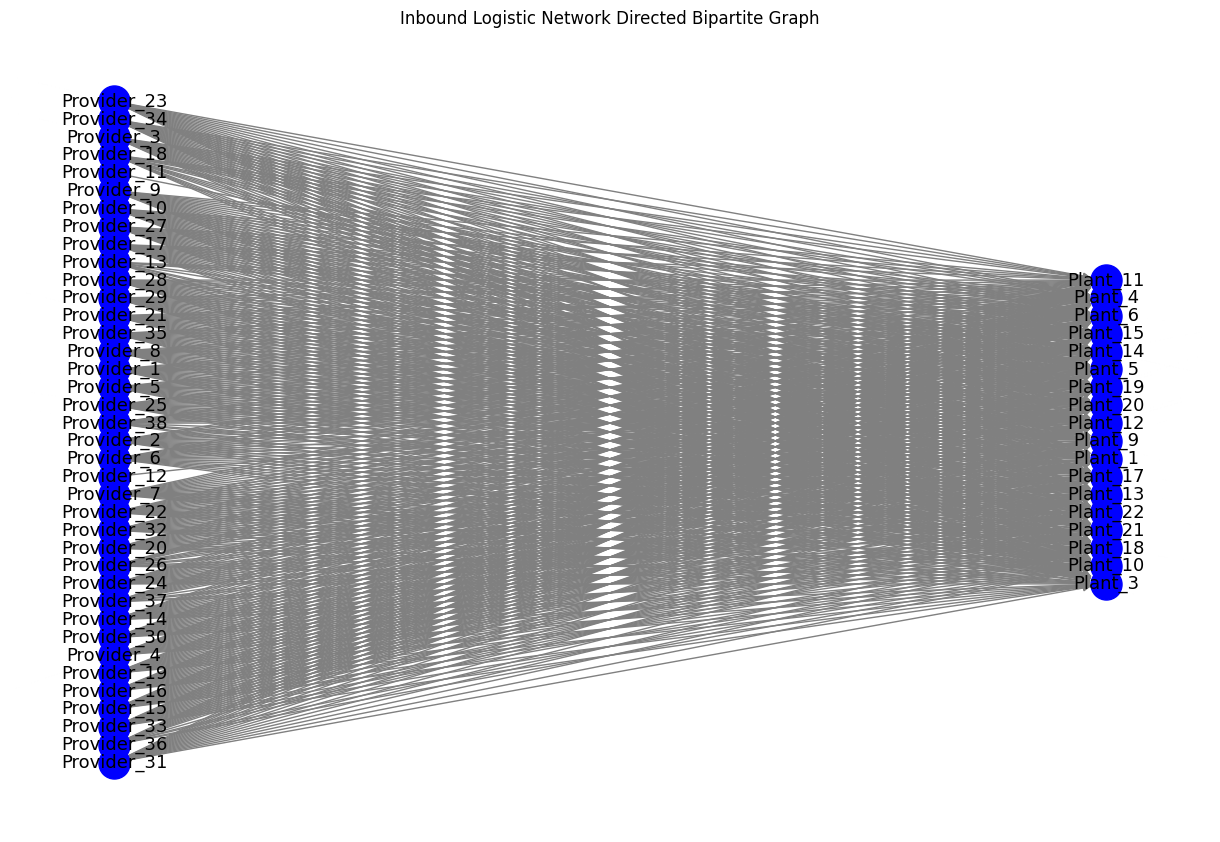

In [18]:
file_name =  f"Inbound_Logistics_Network_Bipartite_Graph.png"
output_path = os.path.join("../img", file_name)

plt.figure(figsize=(12, 8))
pos = nx.multipartite_layout(inbound_log_graph, subset_key="bipartite")

# Draw the subgraph
nx.draw(
    inbound_log_graph,
    pos,
    with_labels=True,
    node_color="blue",
    edge_color="gray",
    node_size=500,
    font_size=13,
)

plt.title(f"Inbound Logistic Network Directed Bipartite Graph")
plt.savefig(output_path)

On the other side, while plotting the network for only two providers we can better appreciate the network.

Text(0.5, 1.0, 'Inbound Logistic Network for providers Provider_4 and Provider_1')

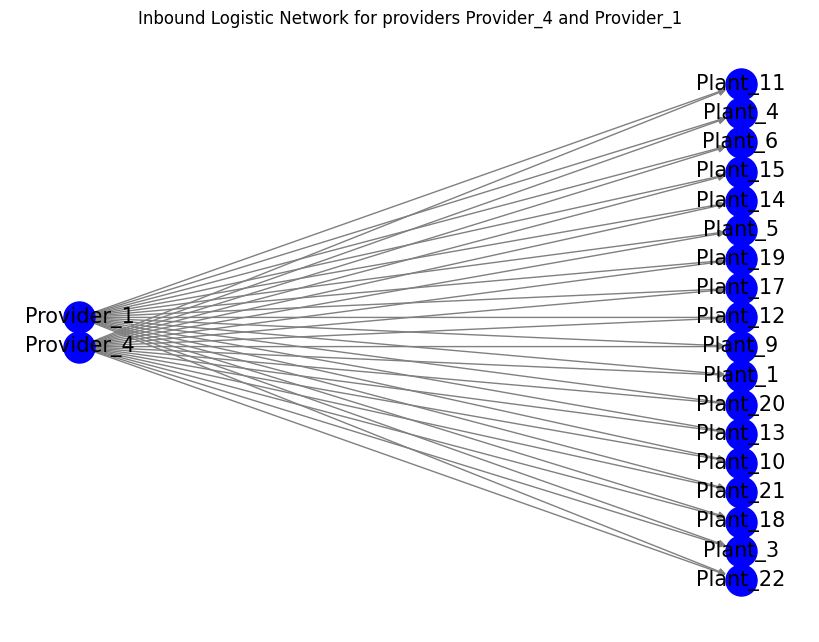

In [19]:
node = 'Provider_4'
node2 = 'Provider_1'
neighbors = list(inbound_log_graph.neighbors(node)) + [node]
neighbors2 = list(inbound_log_graph.neighbors(node2)) + [node2]

subgraph = inbound_log_graph.subgraph(neighbors + neighbors2)
plt.figure(figsize=(8, 6))
pos = nx.multipartite_layout(subgraph, subset_key="bipartite")

# Draw the subgraph
nx.draw(
    subgraph,
    pos,
    with_labels=True,
    node_color="blue",
    edge_color="gray",
    node_size=500,
    font_size=15,
)

plt.title(f"Inbound Logistic Network for providers {node} and {node2}")

### Data Preparation

#### Preparation Historical Volume Data

In [20]:
df_vol_bronze = df_vol.copy()
df_vol = preprocessing_volume_data(df_vol=df_vol_bronze)

In [21]:
df_vol.describe()

,Timestamp,Actual_Vol_[Kg],Expected_Vol_[Kg],Year,Month,Actual_Vol_[Tons],Expected_Vol_[Tons]
count,47058,4.705500e+04,4.695100e+04,47058.000000,47058.000000,47055.000000,46951.000000
mean,2018-05-12 19:43:06.510263552,4.446285e+05,8.292719e+05,2017.912172,6.412002,444.628452,829.271898
min,2014-01-01 00:00:00,1.000000e+00,0.000000e+00,2014.000000,1.000000,0.001000,0.000000
25%,2016-05-01 00:00:00,7.908550e+04,6.820250e+04,2016.000000,3.000000,79.085500,68.202500
50%,2018-06-01 00:00:00,2.480090e+05,2.206440e+05,2018.000000,6.000000,248.009000,220.644000
75%,2020-06-01 00:00:00,5.767820e+05,5.253174e+05,2020.000000,9.000000,576.782000,525.317500
max,2022-10-01 00:00:00,5.880148e+07,5.165009e+08,2022.000000,12.000000,58801.478000,516500.852000
std,NaN,7.162504e+05,9.156459e+06,2.430827,3.421207,716.250404,9156.458726


In [22]:
print("The historical transport volume data contains data since", df_vol['Timestamp'].min(), " until ", df_vol['Timestamp'].max())
print("in Total it contains data for", df_vol['ts_key'].nunique(), " inbound logistics Provider-Plant connections")
print("in Total it contains data for", df_vol['Plant'].nunique(), " plants")
print("in Total it contains data for", df_vol['Provider'].nunique(), " Providers")
print("in Total it contains ", df_vol.shape[0], " rows.")
print("in Total it contains ", df_vol.shape[1], " columns.")

The historical transport volume data contains data since 2014-01-01 00:00:00  until  2022-10-01 00:00:00
in Total it contains data for 624  inbound logistics Provider-Plant connections
in Total it contains data for 18  plants
in Total it contains data for 38  Providers
in Total it contains  47058  rows.
in Total it contains  10  columns.


In [36]:
# Store to silver
df_vol.to_parquet(config['preprocessing']['vol_silver_path'])

##### Data Quality and Data Completeness

One of the most important aspects in timeseries forecasting is to verify whether the timeseries have the same length. 

In [ ]:
data_quality_vol_analysis(df_vol=df_vol)

The previous analysis shows us how important it is to verify which time series actually meet the criteria for forecasting. In our case, we found out that only 49% of all time series are available at the last max date. These are the timeseries that will be relevant for forecasting, as indicated by the business team. From now on, we will focus on these time series to analyze their patterns and create the forecast.

#### Preparation Production Data

In [23]:
df_prod_bronze = df_prod.copy()
df_prod = preprocessing_production(df_prod=df_prod_bronze)

In [24]:
df_prod.describe()

,Timestamp,Production
count,2160,2160.000000
mean,2018-12-16 04:00:00,50819.738889
min,2014-01-01 00:00:00,0.000000
25%,2016-06-23 12:00:00,12068.500000
50%,2018-12-16 12:00:00,27149.500000
75%,2021-06-08 12:00:00,65724.000000
max,2023-12-01 00:00:00,409207.000000
std,NaN,71122.341270


In [25]:
print("The historical production data contains data since", df_prod['Timestamp'].min(), " until ", df_prod['Timestamp'].max())
print("in Total it contains ", df_prod.shape[0], " rows.")
print("in Total it contains ", df_prod.shape[1], " columns.")
print("Total available Plants are: ", df_prod['Plant'].nunique())
print("Max Production Volume was: ", df_prod['Production'].max(), " units. In", 
    df_prod[df_prod['Production'] == df_prod['Production'].max()]['Timestamp'].values[0])
print("Min Production Volume was: ", df_prod['Production'].min(), " units. In", 
      df_prod[df_prod['Production'] == df_prod['Production'].min()]['Timestamp'].values[0])

The historical production data contains data since 2014-01-01 00:00:00  until  2023-12-01 00:00:00
in Total it contains  2160  rows.
in Total it contains  3  columns.
Total available Plants are:  18
Max Production Volume was:  409207  units. In 2015-07-01T00:00:00.000000000
Min Production Volume was:  0  units. In 2020-04-01T00:00:00.000000000


In [34]:
# Store to silver
df_prod.to_parquet(config['preprocessing']['prod_silver_path'])

#### Preparation Covid Data

In [ ]:
df_covid_bronze = df_covid.copy() 
df_covid = preprocesing_covid(df_covid=df_covid_bronze)

The Covid data ranges from 2020-01-06 00:00:00  until  2023-11-20 00:00:00
The file contains data for  29  countries.
The file contains data for  6  age groups  ['<15yr' '15-24yr' '25-49yr' '50-64yr' '65-79yr' '80+yr']
in Total it contains  35496  rows.
in Total it contains  9  columns.


In [31]:
print("Available countries ", df_covid.columns[1:])

Available countries  Index(['Belgium', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden'],
      dtype='object', name='country')


In [ ]:
# Store to silver
df_covid.to_parquet(config['preprocessing']['covid_silver_path'])

### Exploratory Data Analysis

#### Volume Data

To visualise the time series, we can plot a line graph over time for the Actual and Expected Vol columns. 

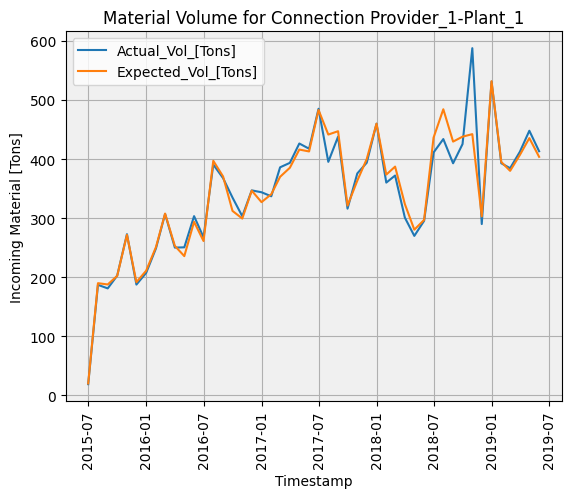

<Figure size 1200x500 with 0 Axes>

In [38]:
ts_key = "Provider_1-Plant_1"
x_axis = "Timestamp"
y1_axis = "Actual_Vol_[Tons]"
y2_axis = "Expected_Vol_[Tons]"
_df = df_vol.query(f" ts_key == '{ts_key}'")
x = _df[x_axis]
y1 = _df[y1_axis]
y2 = _df[y2_axis]


fig, ax = plt.subplots()

plt.rc("text", usetex=False)
plt.figure(figsize=(12, 5))

ax.plot(x, y1, label=y1_axis)
ax.plot(x, y2, label=y2_axis)
ax.grid(True)
ax.set_facecolor("#f0f0f0")
ax.set_xlabel(x_axis)
ax.tick_params(axis="x", rotation=90)
ax.set_ylabel("Incoming Material [Tons]")
ax.set_title(f"Material Volume for Connection {ts_key}")
ax.legend()

plt.show()

Here we can see that the `Actual Volume` and the `Expected Volume` are close to each other, indicating that they are highly correlated. We can check this by calculating the trend line of the two variables and plotting the actual vs expected volume in a scatter plot. The values of $R^2$ and *Correlation Coefficient* give us a sense of how strongly these two variables are correlated. 

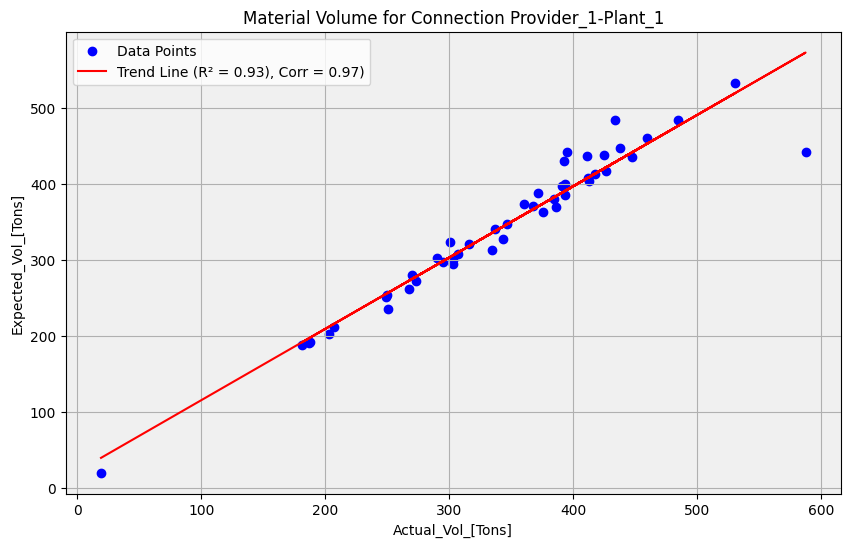

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

ts_key = "Provider_1-Plant_1"
y1_axis = "Actual_Vol_[Tons]"
y2_axis = "Expected_Vol_[Tons]"
_df = df_vol.query(f"ts_key == '{ts_key}'")
y1 = _df[y1_axis].values.reshape(-1, 1)
y2 = _df[y2_axis].values.reshape(-1, 1)

# Fit linear regression model
model = LinearRegression()
model.fit(y1, y2)
y2_pred = model.predict(y1)
r2 = r2_score(y2, y1)

corr_coeff = np.corrcoef(y1.flatten(), y2.flatten())[0, 1] 

fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
ax.scatter(y1, y2, label="Data Points", color="blue")

# Plot trend line
ax.plot(y1, y2_pred, color="red", label=f"Trend Line (R² = {r2:.2f}), Corr = {corr_coeff:.2f})")

ax.grid(True)
ax.set_facecolor("#f0f0f0")
ax.set_xlabel(y1_axis)
ax.set_ylabel(y2_axis)
ax.set_title(f"Material Volume for Connection {ts_key}")
ax.legend()

plt.show()

For the Provider1-Plant1 connection, the correlation coefficient exceeds 0.5, indicating a strong positive correlation between the variables. However, it’s important to note that correlation does not imply causation. Since this analysis is based on observational data, we cannot infer any causal relationship; the data merely reflects associations without controlled experimentation as explained by Çetinkaya-Rundel and Hardin [Introduction to modern statistics](https://openintro-ims.netlify.app/).

We can now analyze the distibution of the Correlation Coefficients across all time series, to verify if this positive correlation is observed in all timeseries connections.

In [43]:
correlations = []
for ts_key in df_vol["ts_key"].unique():

    # Expected Volume might not be available for all past months
    _df = df_vol.query(f" ts_key == '{ts_key}'").dropna()

    # Only if there are at least more than 8 expected VOlume data points, then 
    # calculate the corr coefficient
    if _df.shape[0] > 8:
        x = _df[x_axis]
        y1 = _df[y1_axis]
        y2 = _df[y2_axis]
        corr = np.corrcoef(y1, y2)[0, 1]
        correlations.append(corr)

    del _df

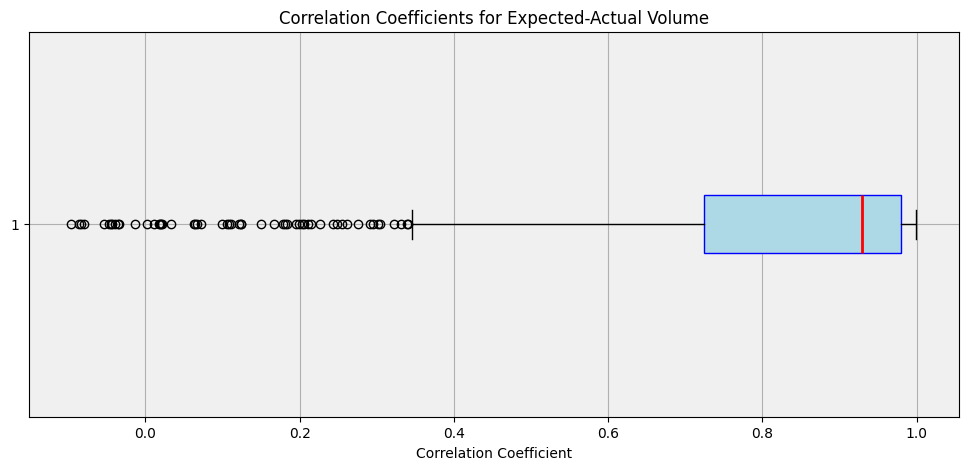

In [44]:
fig, ax = plt.subplots(figsize=(12, 5))

# Box plot with custom appearance
ax.boxplot(correlations, vert=False, patch_artist=True, 
           boxprops=dict(facecolor="lightblue", color="blue"),
           medianprops=dict(color="red", linewidth=2))

ax.set_facecolor("#f0f0f0")
ax.set_xlabel("Correlation Coefficient")
ax.set_title("Correlation Coefficients for Expected-Actual Volume")
ax.grid(True)

plt.show()

In [45]:
_df = pd.DataFrame({'correlation_Expected_Actual':correlations})
_df.describe()

,correlation_Expected_Actual
count,565.000000
mean,0.792467
std,0.275825
min,-0.096765
25%,0.724799
50%,0.929280
75%,0.979473
max,0.999686


We calculated the correlation coefficients for 565 time series. The box plot reveals that the median correlation between Expected and Actual Volume is 0.92, with the 25th percentile at 0.72 and the 75th percentile at 0.97. This indicates that most time series exhibit a strong positive correlation. However, a few outliers show correlation coefficients below 0.3, suggesting weaker relationships for those specific cases. Overall, the data demonstrates that the majority of time series have moderate to strong positive correlations between the two variables.

In [53]:
df_vol.head()

,Timestamp,Provider,Plant,Actual_Vol_[Kg],Expected_Vol_[Kg],Year,Month,ts_key,Actual_Vol_[Tons],Expected_Vol_[Tons]
0,2015-07-01,Provider_1,Plant_1,19096.0,20298.0,2015,7,Provider_1-Plant_1,19.096,20.298
1,2015-08-01,Provider_1,Plant_1,187139.0,189973.0,2015,8,Provider_1-Plant_1,187.139,189.973
2,2015-09-01,Provider_1,Plant_1,181149.0,187798.0,2015,9,Provider_1-Plant_1,181.149,187.798
3,2015-10-01,Provider_1,Plant_1,202677.0,202327.0,2015,10,Provider_1-Plant_1,202.677,202.327
4,2015-11-01,Provider_1,Plant_1,272902.0,271765.0,2015,11,Provider_1-Plant_1,272.902,271.765


#### Production Data

We can visualize all the productions volumes of all plants together. 

In [48]:
df_prod.head()

,Timestamp,Plant,Production
0,2014-01-01,Plant_6,11848
1,2014-02-01,Plant_6,13528
2,2014-03-01,Plant_6,12753
3,2014-04-01,Plant_6,12681
4,2014-05-01,Plant_6,13272


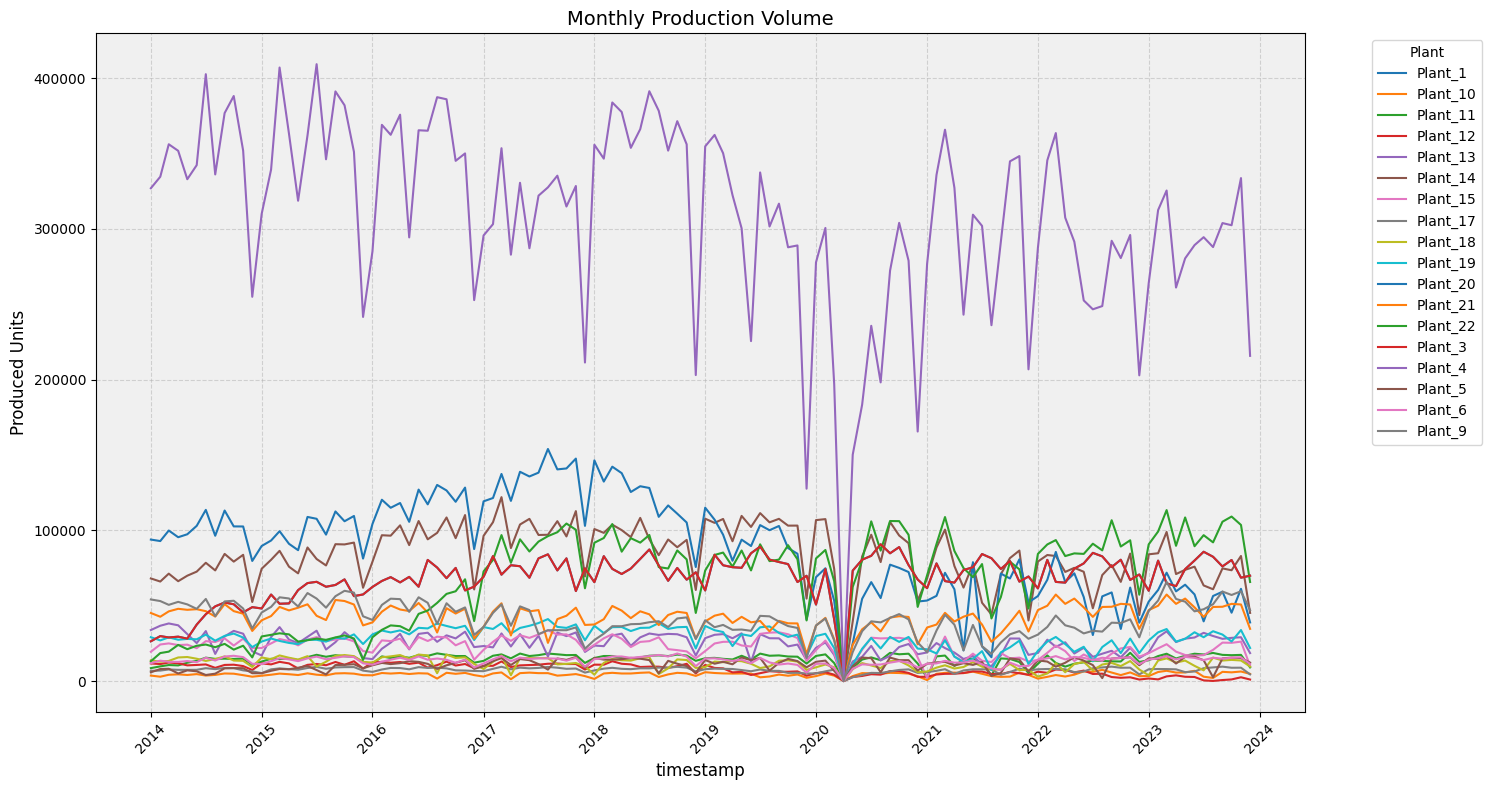

In [51]:
# Free up memory and close all figures
plt.close('all')

plt.figure(figsize=(15, 8))

df_prod_pivot = df_prod.pivot(index='Timestamp', columns='Plant', values='Production')

# Plot each country's line
for plant in df_prod_pivot.columns:
    plt.plot(df_prod_pivot.index, df_prod_pivot[plant], label=plant)

plt.title('Monthly Production Volume', fontsize=14)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Produced Units', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.5)  
plt.gca().set_facecolor('#f0f0f0')  
plt.legend(title='Plant', bbox_to_anchor=(1.05, 1), loc='upper left')  

# Show plot
plt.tight_layout()  
plt.show()

We can observe that data reveals a **strong 12-month seasonal pattern** in production volumes across the plants. Specifically, production levels tend to dip during the summer and winter months, indicating potential seasonality in demand, operational constraints, or planned maintenance periods during these times.

A significant anomaly is observed in April 2020, coinciding with the onset of the **COVID-19 outbreak and subsequent global lockdowns**. During this period, production dropped to nearly zero across all plants, suggesting a widespread halt in operations. This disruption is a clear outlier in the time series, with a sharp recovery observed in the following months as operations resumed.

#### Covid Data

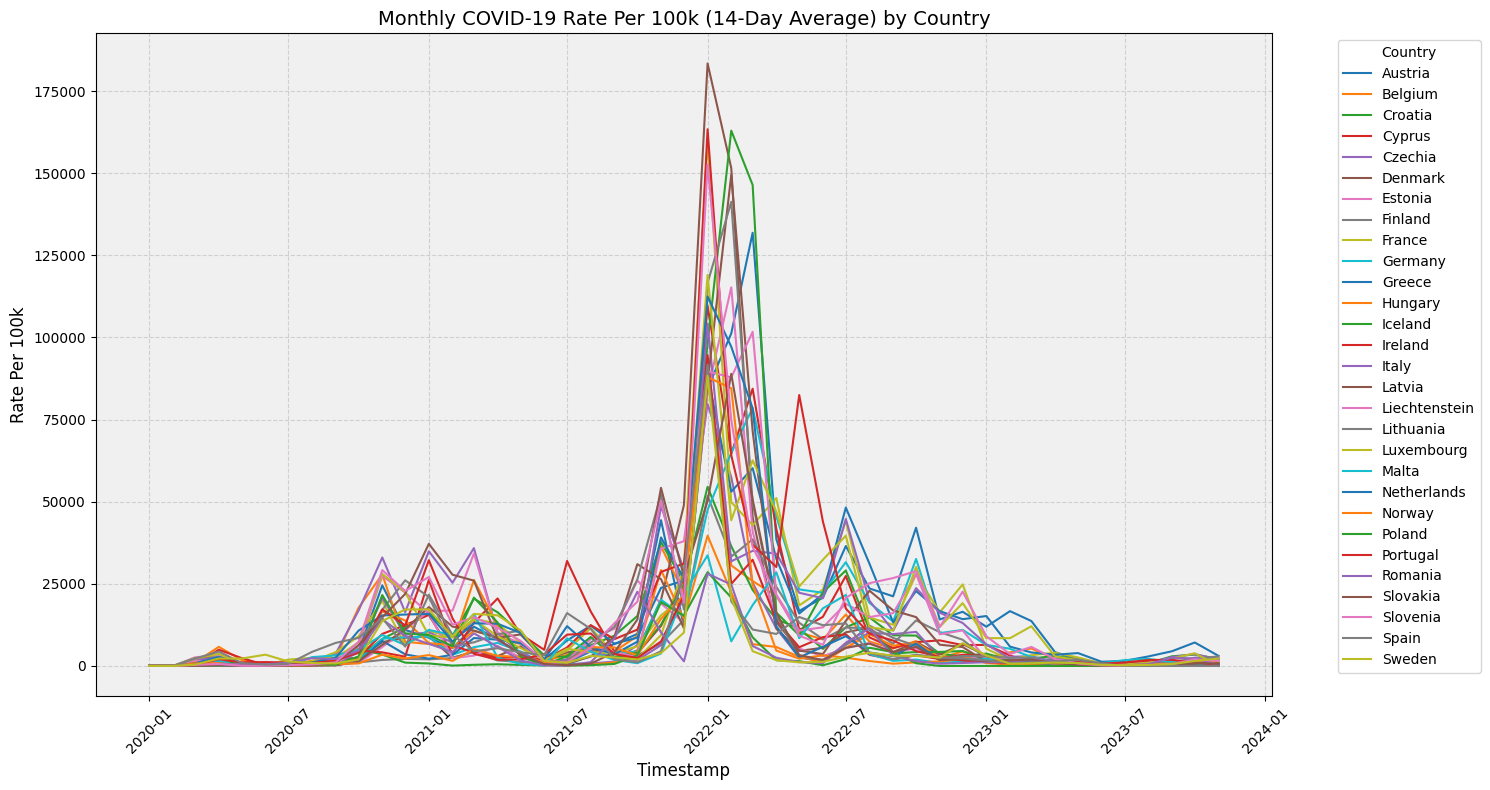

In [29]:
# Free up memory and close all figures
plt.close('all')

plt.figure(figsize=(15, 8))

# Plot each country's line
for country in df_covid.columns:
    plt.plot(df_covid.index, df_covid[country], label=country)

plt.title('Monthly COVID-19 Rate Per 100k (14-Day Average) by Country', fontsize=14)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Rate Per 100k', fontsize=12)
plt.xticks(rotation=45)  
plt.grid(True, linestyle='--', alpha=0.5)  
plt.gca().set_facecolor('#f0f0f0')  
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')  

# Show plot
plt.tight_layout()  
plt.show()

This plot above illustrates the monthly COVID-19 rate per 100,000 inhabitants across various countries. The first notable peak occurs during the initial lockdowns in mid-2020 and early 2021, coinciding with the widespread implementation of strict public health measures. These peaks likely reflect the limited immunity in populations prior to the widespread availability of vaccines. [World Data](https://ourworldindata.org/covid-cases)

Following the relaxation of restrictions, the graph shows a subsequent surge in case rates, particularly in late 2021 and early 2022. This trend aligns with the emergence of more transmissible variants, such as Delta and Omicron, and the lifting of social distancing measures. However, the overall rates stabilize over time, likely due to increased vaccine coverage and natural immunity from prior infections. The reduction in case rates in late 2022 and 2023 also suggests improved public health management, including booster campaigns and effective treatments. (Tartof SY et al., 2024) Estimated Effectiveness of the BNT162b2 XBB Vaccine Against COVID-19. [link](https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2820268)

This plot provides a clear temporal view of how the pandemic evolved, highlighting the impact of interventions like lockdowns and vaccinations on transmission rates.

We are interested in evaluating how much these numbers would influence the forecasting accuracy. As multiple disruptions occurred in the supply chain due to the covid lockdowns and restrictions. For example an increased volatility as researched by [Capgemini](https://www.capgemini.com/wp-content/uploads/2020/11/Fast-forward_Report.pdf).

### Predictor Variable

In Timeseries forecasting it is common to carry out feature engineering using the response variable. For time dependent variables the common approach is to calculate lagged values as well as rolling statistics, e.g., rolling mean and rolling standard deviation. As for example explained by Manu Joseph in the chapter [Feature Engineering for Timeseries](https://github.com/PacktPublishing/Modern-Time-Series-Forecasting-with-Python/blob/main/notebooks/Chapter06/01-Feature%20Engineering.ipynb) in the book [Modern Timeseries Forecasting with Python](https://www.oreilly.com/library/view/modern-time-series/9781835883181/).

For the **historical transport volume** data the predictor variable would be:

- Provider 
- Plant
- Expected Vol (Lagged Values, Rolling Mean, Rolling Std)
- Acutual Vol ( Lagged Values, Rolling Mean, Rolling Std)
- Year
- Month

For the **Covid Data Set** the reponse variables would be. After pivoting and transforming the data in order to match the timestamps values, I would use the following columns as predictors:

- monthly_rate_14_day_per_100k_per_country

Regarding the **Production Planning Data** it would be used as a smoothing factor to transform the response variable into the so called `Vol/Prod Ratio`. Because the production data and the inbound volume have a natural correlation. We can use this relationship to create a new target variable that will compensate for variations in the inbound volume. This new variable will be called `Vol/Prod Ratio`. 

This approach is possible since the production planning data is always available on monthly basis for the next 12 months in the future. So if we use `Vol/Prod Ratio` instead of `Actual Vol [Kg]` to train the model, we can then easly multiply the forecast values of `Vol/Prod Ratio` with the Production Planning values to get the forecast of `Actual Vol [Kg]`. 

### Variable lists

### Data splitting

## Analysis

### Descriptive statistics

### Exploratory data analysis

### Relationships

## Model

### Select model

### Training and validation

### Fit model

### Evaluation on test set

### Save model



Save your model in the folder `models/`. Use a meaningful name and a timestamp.

## Conclusions